In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.25937492/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify grid points for densities and metallicities

In [8]:
log_hdens_min = -4.5
log_hdens_max = -2.5
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [9]:
log_metals_min = -0.5
log_metals_max = 1.0
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [10]:
pkl_file = open(rootdir+'final_grid_fixT_z126.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [11]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Column density ratios

In [12]:
logN_dict = {'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            'OVI':'<13.7',
            'NeV':'<13.4',
            'NeVI':'<15.3',
            'NeVIII':'<13.9',
            'MgX':'<13.8',
            'AlII':'<10.9',
            'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',
            'FeII':'<11.5',}

In [13]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'-0.22, -0.30, 0.20'

In [14]:
logN_ratio_dict = {'CIV/CIII': '-0.24, -0.20, 0.20'}

In [15]:
def gen_logN_ratio_pred(species_logN_interp, ion_pairs_list, log_metals_ref,
                        log_hdens_min, log_hdens_max, log_hdens_grid_size):
    
    '''
    Method to generate predicted column density ratios for ionic pairs

    species_logN_interp: Interpolated CLOUDY grid
    ion_pairs_list: list of ionic pairs
    logN_HI_ref: fiducial HI column density to access CLOUDY grid
    log_metals_ref: fiducial metallicity to access CLOUDY grid
    log_hdens_min/max/size: end points and size of gas density grid to evaluate column density ratios
    '''

    # Establish the gas density grid
    log_hdens_grid = np.linspace(log_hdens_min, log_hdens_max, log_hdens_grid_size)

    # Create grid points
    grid_points = np.array([[log_hdens, log_metals_ref] for log_hdens in log_hdens_grid])

    logN_ratio_pred = {}

    for ion_pair_str in ion_pairs_list:

        ion_pair = ion_pair_str.split('/')
        
        # Get corresponding species
        s1 = ion_species_dict[ion_pair[0]]
        s2 = ion_species_dict[ion_pair[1]]
        
        # Extract column density ratio from grid
        logN_ratio_pred[ion_pair_str] = species_logN_interp[s1](grid_points)-species_logN_interp[s2](grid_points)

    return log_hdens_grid, logN_ratio_pred

In [16]:
def plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, log_metals_ref = 0.0,
                    log_hdens_min = -4.5, log_hdens_max = -2.5, log_hdens_grid_size = 5000,
                    colors = ['black', 'darkgray', 'firebrick', 'tan', 'deepskyblue', 
                            'cyan', 'green', 'yellowgreen', 'darkmagenta', 'orchid',
                            'darkorange', 'orangered', 'goldenrod', 'indigo', 'blueviolet',
                            'crimson'],
                    linestyles = ['-', '-', '-', '-', '-', 
                            '-', '-', '-', '-', '-',
                            '-', '-', '-', '-', '-',
                            '-'], label=True):

    '''
    Method to overplot predicted and observed column density ratios as a function of gas density

    ax: the axes object
    species_logN_interp: interpolated CLOUDY grid
    logN_ratio_dict: dictionary of observed column densities
    '''

    # Generate grid of gas density and column density ratio predictions
    log_hdens_grid, logN_ratio_pred = gen_logN_ratio_pred(species_logN_interp, list(logN_ratio_dict.keys()), 
                        log_metals_ref,
                        log_hdens_min, log_hdens_max, log_hdens_grid_size)
    

    # Plot the predicted column density ratios
    for i in range(len(logN_ratio_pred)):
        
        ion_pair_str = list(logN_ratio_pred.keys())[i]
        
        # Plot model predictions
        ax.plot(log_hdens_grid, logN_ratio_pred[ion_pair_str], label=ion_pair_str, c=colors[i], ls=linestyles[i])
        
    # Plot the observed column density ratios
    for i in range(len(logN_ratio_dict)):

        ion_pair_str = list(logN_ratio_dict.keys())[i]
        
        # Observed column density ratio
        logN_ratio_str = logN_ratio_dict[ion_pair_str]
        
        # If upper limit
        if logN_ratio_str[0] == '<':
            idx = (logN_ratio_pred[ion_pair_str] < float(logN_ratio_str[1:].split(',')[0]))
        
        # If lower limit
        elif logN_ratio_str[0] == '>':
            idx = (logN_ratio_pred[ion_pair_str] > float(logN_ratio_str[1:].split(',')[0]))   
            
        # For detection
        else:
            logN_ratio_list = logN_ratio_str.split(',')
            logN_lo = float(logN_ratio_list[0]) + float(logN_ratio_list[1]) # Mind the negative sign
            logN_hi = float(logN_ratio_list[0]) + float(logN_ratio_list[2])
            
            idx = (logN_ratio_pred[ion_pair_str] > logN_lo) & (logN_ratio_pred[ion_pair_str] < logN_hi)

        mask = np.ones(len(log_hdens_grid))
        mask[~idx] = np.nan
            
        ax.plot(log_hdens_grid*mask, logN_ratio_pred[ion_pair_str]*mask, lw=4, c=colors[i], ls=linestyles[i])
    
    ax.set_xlabel(r'$\log (n_{\mathrm{H}}/\mathrm{cm}^{-3})$')
    ax.set_ylabel(r'$\log (\mathrm{Column Density Ratio})$')

    if label==True:
        ax.legend(loc='right', bbox_to_anchor=(1.38, 0.5),
                fancybox=True, shadow=True, ncol=1)
    

(-4.2, 2.5)

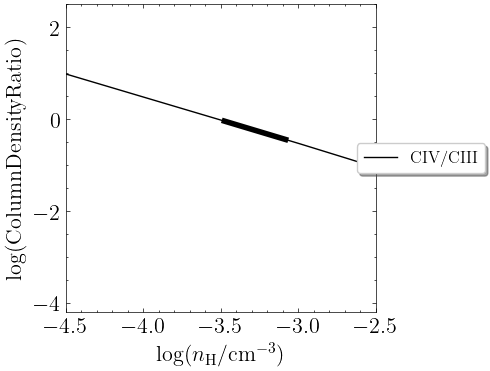

In [17]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-4.5, -2.5)
ax.set_ylim(-4.2, 2.5)

# Single phase solution

In [18]:
def log_prior(params):
    
    '''
    Priors for an MCMC search. 

    params_dict: Dictionary of parameters being fitted. Will contain logN_HI, n_H, [O/H], and [X/H]
    '''

    # Grid parameters being varied
    log_hdens, log_metals, non_solar_dict = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    if log_hdens_min<log_hdens<log_hdens_max and log_metals_min<log_metals<log_metals_max:

        relative_abund = True

        # Check if other elemental abundances are within bounds
        for k in list(non_solar_dict.keys()):
            relative_abund *= (-3.0<non_solar_dict[k]+log_metals<log_metals_max)

        if relative_abund == True:
            return 0.
        else:
            return -np.inf
    return -np.inf

In [19]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [20]:
def log_likelihood(params, logN_dict, species_logN_interp):

    '''
    Likelihood function for comparing CLOUDY predicted column densities to the observed values from VP fit.
    If only some of the parameters need to be fit, the log_likelihood function can be overridden with a lambda function
    which calls this likelihood function with only some parameters being varied.

    params: parameters needed to generate CLOUDY predicted column densities
    logN_dict: dictionary of measured column densities from VP fit
    species_logN_interp: interpolated CLOUDY grid
    '''
    
    # Grid parameters being varied
    log_hdens, log_metals, non_solar_dict = params

    # Likelihood function
    ll = 0
    
    ions = list(logN_dict.keys())
    
    # Ignore first entry since it's HI
    for i in range(len(ions)):
        
        # This is from VP fit
        ion = ions[i]
        logN_str = logN_dict[ion]
        
        # This is from CLOUDY
        s = ion_species_dict[ion]
        
        # Get interpolated column density from CLOUDY grid
        y_bar = species_logN_interp[s]([log_hdens, log_metals])[0]

        # If there is departure from solar abundance, shift the predicted column density accordingly
        if s.split('+')[0] in non_solar_dict:
            y_bar += non_solar_dict[s.split('+')[0]]

        # Based on detection or non-detection, compute the likelihood term
        
        # Detection
        if logN_str[0] != '<' and logN_str[0] != '>':
            
            logN_arr = np.array(logN_str.split(','), dtype=float)
            
            # Observed column density
            y = logN_arr[0]

            # Use avg. of lower and upper error for defining Gaussian distribution of column density
            sig_y = .5*(-logN_arr[1]+logN_arr[2])  #max(-logN_arr[1], logN_arr[2])

            # Gaussian likelihood
            ll += -.5*(y-y_bar)**2/sig_y**2

        # Upper limit
        elif logN_str[0] == '<':
            
            logN_arr = np.array(logN_str[1:].split(','), dtype=float)

            # Isolate the lower limit and sigma
            y = logN_arr[0]
            sig_y = 0.14

            y_range_min = -10 # Should extend to infinity, ideally
            y_range_step = 0.05

            y_range = np.arange(y_range_min, y+y_range_step, y_range_step)

            # CDF, marginalize over reported values
            ll += np.log(integrate.simpson(x=y_range, y=np.exp(-.5*(y_range-y_bar)**2/sig_y**2)))
            
        # Lower limit
        # NOTE: not implemented yet
        elif logN_str[0] == '>':

            logN_arr = np.array(logN_str[1:].split(','), dtype=float)

            # Isolate the lower limit and sigma
            y = logN_arr[0]
            sig_y = 0.14

            y_range_max = 21.5 # Should extend to infinity, ideally
            y_range_step = 0.05

            y_range = np.arange(y, y_range_max+y_range_step, y_range_step)

            # "Q"-function, marginalize over reported values
            ll += np.log(integrate.simpson(x=y_range, y=np.exp(-.5*(y_range-y_bar)**2/sig_y**2)))

    # Return log likelihood for MCMC
    return ll

In [21]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [22]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [23]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [24]:
log_hdens_test = -3.3
log_metals_test = 0.4
C_O_test = 0.0
N_O_test = -2.0

In [25]:
def predict_col_dens(logN_dict, log_hdens, log_metals, species_logN_interp, X_alpha_dict = {}):

    '''
    Predict column densities for an ordered list of ions given an interpolated CLOUDY grid across N_HI, n_H, and [M/H].
    If there are departures from solar abundance patterns, the column densities will be shifted appropriately
    '''

    # Generate sorted list of ions according to ionization potential
    ions_ordered = [s for s in list(IP_dict.keys()) if s in list(logN_dict.keys())]

    logN_species_test = []

    # Respect ordering of ions
    # The hope is that the HI column density from the grid will just be the test value, if interpolation proceeded properly
    for i in range(len(ions_ordered)):
            
        ion = ions_ordered[i]   
        s = ion_species_dict[ion]

        # Get predicted column density for the species from CLOUDY
        logN_s = species_logN_interp[s]((log_hdens, log_metals))

        # If there is departure from solar abundance, shift the predicted column density accordingly
        # s.split('+')[0] is supposed to be the element name. This won't work for hydrogen, or helium, but they're not metals anyway
        if s.split('+')[0] in X_alpha_dict:
            logN_s += X_alpha_dict[s.split('+')[0]]

        # Get interpolated column density from CLOUDY grid
        logN_species_test.append(logN_s)

    return np.array(logN_species_test)

In [26]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [27]:
logN_species_test = np.array(predict_col_dens(logN_dict, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

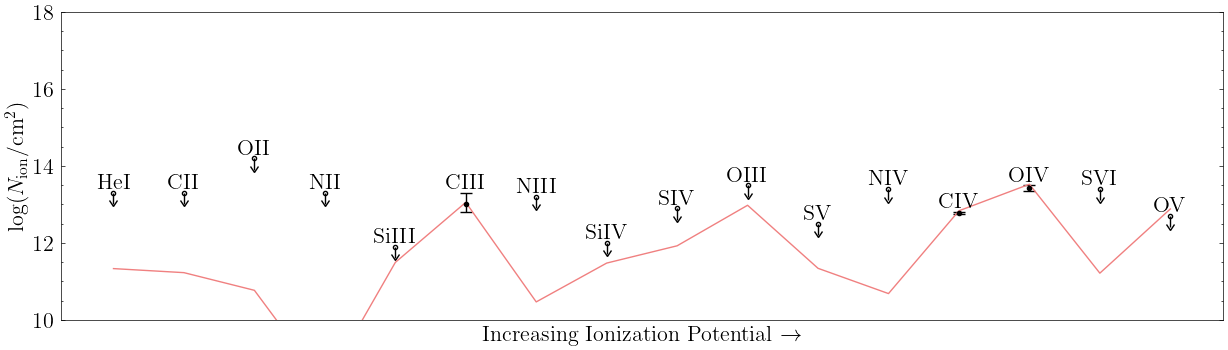

In [28]:
fig, ax = plot_column_densities_obs(logN_dict)
#ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
#ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [29]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [30]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [33]:
#sampler.run_mcmc(pos, 500, progress=True);

In [34]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase_fixT.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase_fixT.csv')

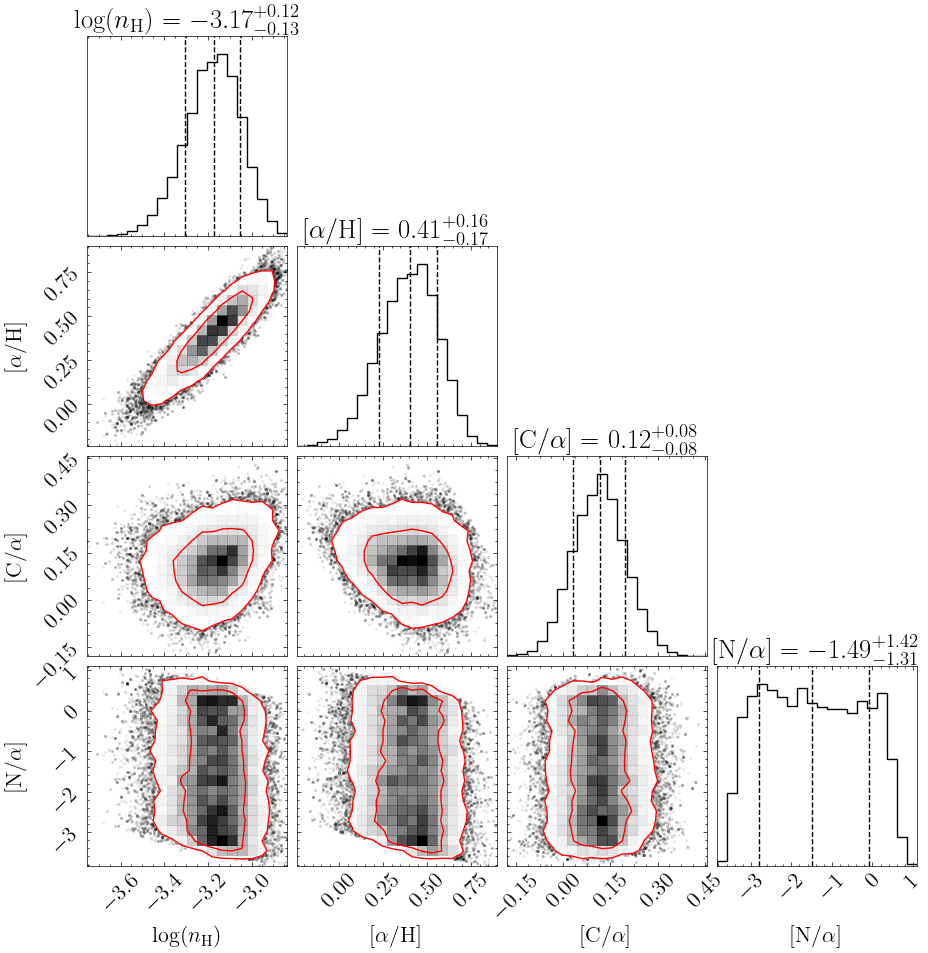

In [68]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{\alpha/H}]$', r'$[\mathrm{C/\alpha}]$', r'$[\mathrm{N/\alpha}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [65]:
np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)-np.median(flat_samples['log_hdens'])

0.11811210765651925

In [66]:
np.median(flat_samples['log_hdens'])-np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))

0.13460903017721026

In [67]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.8247613132644834

Now plot the best models

In [49]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            #'HeI':'<13.3',
            #'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            #'NII':'<13.3',
            #'NIII':'<13.2',
            'NIV':'<13.4',
            #'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',}
            #'SIV':'<12.9',
            #'SV':'<12.5',
            #'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [50]:
b_dict = {'HI':'20, -2, +2',
          'CIII':'6.0, -0.7, +0.7',
          'CIV':'6.0, -0.7, +0.7',
          'OIV':'6.0, -0.7, +0.7'}

In [51]:
z_sys = 1.25937492

In [52]:
import matplotlib.lines as mlines

In [53]:
logN_species_best = predict_col_dens(logN_dict, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [54]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [55]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

logN_res_up['SiIV'] = '<0.4'
logN_res_up['OIII'] = '<0.4'
logN_res_up['NIV'] = '<0.4'

In [56]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [57]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

(3.0, 27.0)

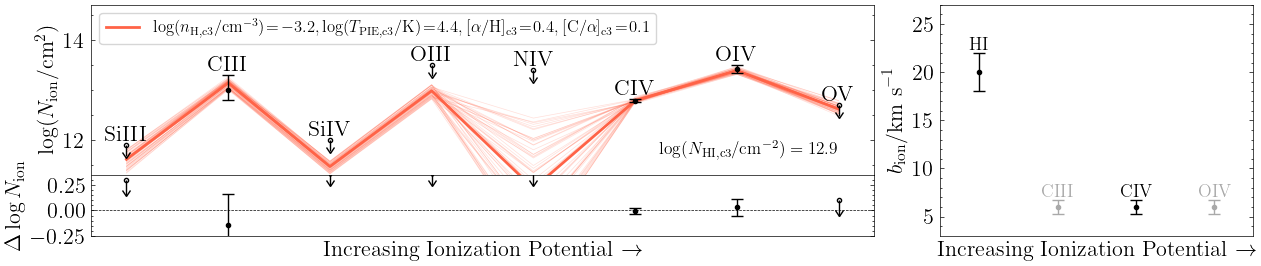

In [69]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(11.3,14.7)

#axd['upper left'].text(len(logN_dict)-1, 13.7, r'PIE', fontsize=14,horizontalalignment='right')
axd['upper left'].text(len(logN_dict)-1, 11.7, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 12.9$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -3.2, \log(T_\mathrm{PIE,c3}/\mathrm{K})\!=\!4.4, \mathrm{[\alpha/H]_{c3}} \!=\! 0.4, \mathrm{[C/\alpha]_{c3}}\!=\!0.1$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-.25,.35)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

#plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [59]:
def get_cloud_size(log_hdens, species_logN_interp, log_metals):

    logN_HII = species_logN_interp['H+']((log_hdens, log_metals))
    N_H = 10**12.9 + 10**logN_HII

    l = (N_H/10**log_hdens)*3.24078e-19*1e-3 # in kpc

    return l

In [60]:
l = get_cloud_size(flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

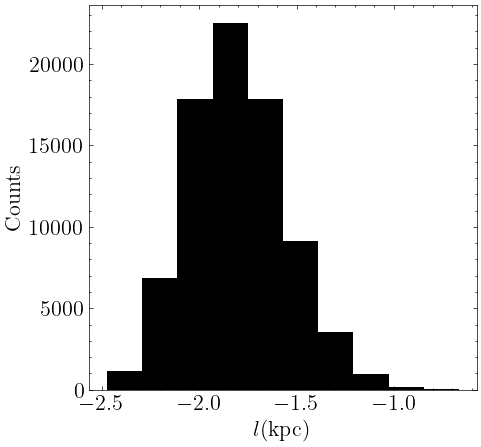

In [61]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$l (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [62]:
get_quantiles(np.log10(l))

-1.82 -0.23 0.27


In [63]:
np.median(np.log10(l))

-1.8201230489609366

In [64]:
np.percentile(np.log10(l), 100*cdf_1sig)-np.median(np.log10(l))

0.2654168542015152